In [0]:
# Import the machine learning libraries.
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [117]:
# Get the stock quote of Apple Inc.
df = web.DataReader('AAPL', data_source='yahoo', start='2007-01-01', end='2020-08-08') 
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-03,12.368571,11.700000,12.327143,11.971429,309579900.0,10.363638
2007-01-04,12.278571,11.974286,12.007143,12.237143,211815100.0,10.593664
2007-01-05,12.314285,12.057143,12.252857,12.150000,208685400.0,10.518225
2007-01-08,12.361428,12.182858,12.280000,12.210000,199276700.0,10.570165
2007-01-09,13.282857,12.164286,12.350000,13.224286,837324600.0,11.448232
2007-01-10,13.971429,13.350000,13.535714,13.857142,738220000.0,11.996092
2007-01-11,13.825714,13.585714,13.705714,13.685715,360063200.0,11.847687
2007-01-12,13.580000,13.318571,13.512857,13.517143,328172600.0,11.701755
2007-01-16,13.892858,13.635715,13.668571,13.871428,311019100.0,12.008460


In [118]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,3361.000000,3361.000000,3361.000000,3361.000000,3.361000e+03,3361.000000
mean,95.629206,93.761418,94.689356,94.733019,1.075886e+08,89.008748
std,70.156925,68.796011,69.397205,69.531462,9.664071e+07,69.676407
min,11.714286,11.171429,11.341429,11.171429,1.136200e+07,9.671075
25%,35.715714,34.641430,35.290001,35.114285,3.558340e+07,30.398338
50%,81.824287,80.175713,81.272858,81.128571,7.716520e+07,70.985245
75%,130.630005,128.360001,129.580002,129.619995,1.485015e+08,119.696228
max,327.850006,323.350006,324.739990,327.200012,8.432424e+08,326.316681


In [119]:
print(df.shape)

(3361, 6)


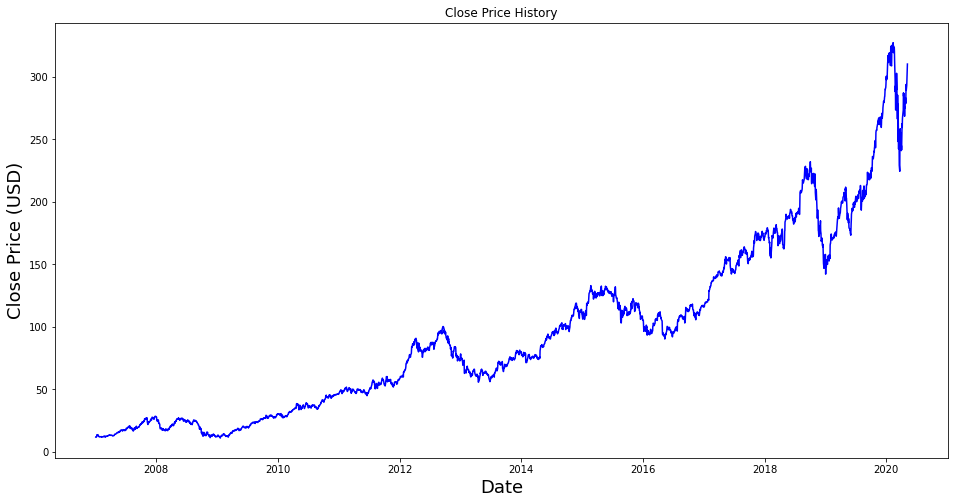

In [120]:
# Visualize the closing price history.
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'], color='b')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [0]:
# Create a new dataframe with only the 'Close' column.
data = df.filter(['Close'])
# Converting the dataframe to a numpy array.
dataset = data.values
# Compute the number of rows to train the model on.
training_data_len = math.ceil( len(dataset) *.8) 

In [0]:
# Min-Max Normalization.
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [0]:
# Create the scaled training dataset.
train_data = scaled_data[0:training_data_len, :]

# Split the data into X_train and y_train data sets
X_train=[]
y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
# Convert x_train and y_train to numpy arrays.
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
# Reshape the data into the shape accepted by the LSTM.
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [126]:
# Build the LSTM network model.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


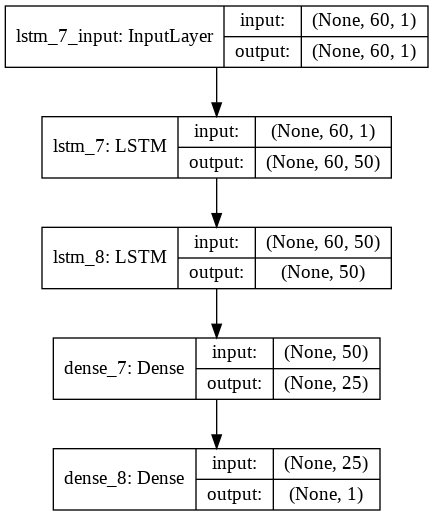

In [127]:
# Visualize.
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [0]:
# Compile the model.
model.compile(optimizer='adam', loss='mean_squared_error')

In [129]:
# Train the model.
model.fit(X_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2629/2629 [==============================] - 107s 41ms/step - loss: 3.2569e-04


In [0]:
# Test dataset.
test_data = scaled_data[training_data_len-60:, :]

# Create the x_test and y_test datasets.
X_test = []
y_test =  dataset[training_data_len:, :]
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [0]:
# Convert x_test to a numpy array.
X_test = np.array(X_test)

In [0]:
# Reshape the data into the shape accepted by the LSTM.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
# Getting the models predicted price values.
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) #Undo scaling

In [134]:
# Calculate/Get the value of RMSE.
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.480061207704517

In [135]:
# Plot/Create the data for the graph.
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


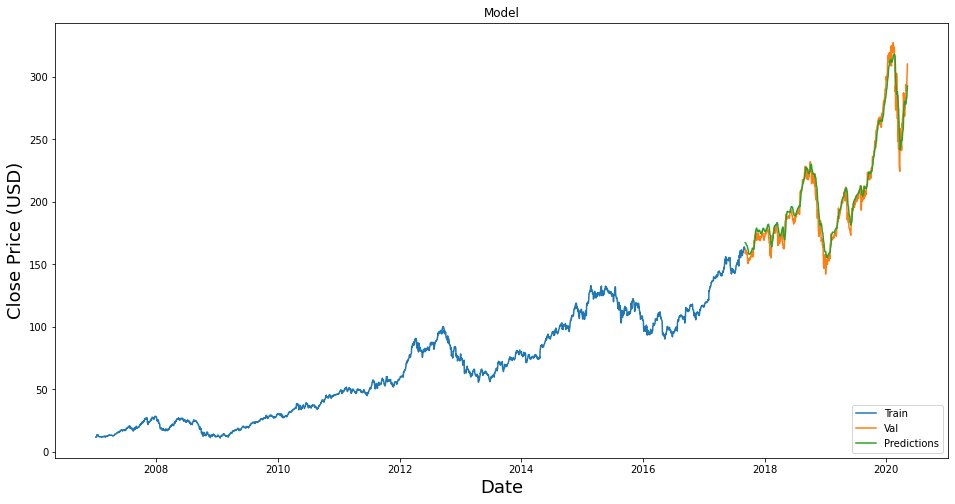

In [136]:
# Visualize the data.
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [137]:
# Show the valid and predicted prices.
valid

,Close,Predictions
Date,,
2017-09-07,161.259995,167.323181
2017-09-08,158.630005,167.246643
2017-09-11,161.500000,166.762741
2017-09-12,160.860001,166.432861
2017-09-13,159.649994,166.140671
...,...,...
2020-05-04,293.160004,283.251221
2020-05-05,297.559998,285.181305
2020-05-06,300.630005,287.450073


In [0]:
# Get the quote.
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2007-01-01', end='2020-08-08')

In [0]:
# Create a new dataframe.
new_df = apple_quote.filter(['Close'])

In [0]:
# Get the last 60 day closing price.
last_60_days = new_df[-60:].values

In [0]:
# Scale the data to be values between 0 and 1.
last_60_days_scaled = scaler.transform(last_60_days)

In [0]:
# Create an empty list.
X_test = []

# Append teh past 60 days.
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array.
X_test = np.array(X_test)

In [0]:
# Reshape the data.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
# Get the predicted scaled price.
pred_price = model.predict(X_test)

In [145]:
# Undo the scaling.
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[295.82623]]
